<a href="https://colab.research.google.com/github/shirakawa24/aaaa/blob/main/Deep_Exemplar_RGBhist_switching__ChoiceVer_%E4%B8%80%E6%B0%97%E3%81%AB%E5%AE%9F%E8%A1%8C_timelaw_12_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.chdir("/content/drive/MyDrive/now_project")
!pip install torch==1.6.0 torchvision==0.7.0

os.chdir("/content/drive/MyDrive/now_project/Deep-Exemplar-based-Video-Colorization")
! pip install -r requirements.txt
#!wget https://facevc.blob.core.windows.net/zhanbo/old_photo/colorization_checkpoint.zip
#!unzip colorization_checkpoint.zip

In [ ]:
from __future__ import print_function
import argparse
import glob
import os
import time

import cv2
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torchvision.transforms as transform_lib
from PIL import Image
from tqdm import tqdm

import lib.TestTransforms as transforms
from models.ColorVidNet import ColorVidNet
from models.FrameColor import frame_colorization
from models.NonlocalNet import VGG19_pytorch, WarpNet
from utils.util import (batch_lab2rgb_transpose_mc, folder2vid, mkdir_if_not,
                        save_frames, tensor_lab2rgb, uncenter_l)
from utils.util_distortion import CenterPad, Normalize, RGB2Lab, ToTensor
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.cuda.set_device(0)

def cv2pil(imgCV):
    imgCV_RGB = imgCV[:, :, ::-1] # H方向とW方向はそのままに、BGRを逆順にする
    imgPIL = Image.fromarray(imgCV_RGB)
    return imgPIL


In [ ]:
!nvidia-smi

Fri Dec  3 14:39:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

0.9start
running on GPU ('0',)
replace all deconv with [nearest + conv]
replace all batchnorm with instancenorm
succesfully load nonlocal model:  checkpoints/video_moredata_l1/nonlocal_net_iter_76000.pth
succesfully load color model:  checkpoints/video_moredata_l1/colornet_iter_76000.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


第一フレームカラー化参照画像セット
第一フレームを参照画像にセット&RGB+Grヒストグラム算出


KeyboardInterrupt: ignored

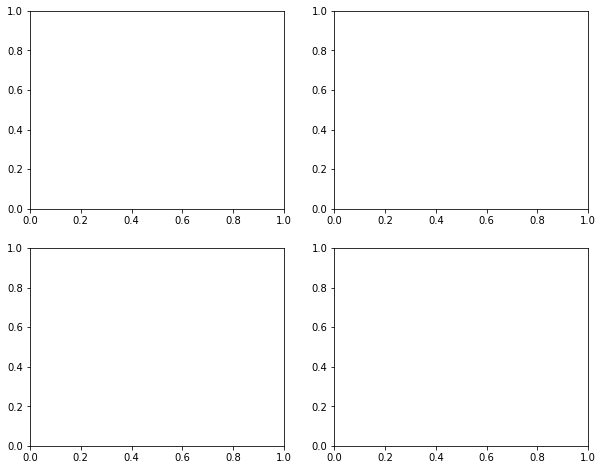

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import time
import copy
import os
import shutil
import numpy as np
from matplotlib import pyplot as plt

#手法
RGB_histoguram = True
RGBgray_histoguram = None
#平滑化係数
smoothing= 1.0

for switch_num in range(1,4,1):         #RGB_histoguram:#1~3つ　RGBgray_histoguram#1~4つ
  for i in np.arange(0.9, 1.0, 0.1):
    x=float(format(i, '.1f'))
    print(str(x)+"start")

    os.chdir("/content/drive/MyDrive/now_project/Deep-Exemplar-based-Video-Colorization")

    

    ###########################################初期設定(Parameter&Path)###########################################################

      #切り替えするかどうか
    switching = True
    #閾値
    red_threshold =x
    green_threshold = x
    blue_threshold = x
    gray_threshold = x
    

    #PSNR算出用
    original_path = "/content/drive/MyDrive/Deep_learning/Dataset/material/shoes/shoes_SparkVideo.mp4"
    csv_name="shoes"
    method = f"RGB_{switch_num}_{x}"

    #input
    # カメラの場合path = 0 
    video_path = "/content/drive/MyDrive/Deep_learning/Dataset/material/shoes/shoes_SparkVideo.mp4"
    capture= cv2.VideoCapture(video_path)
    video_name = f"{method}_{csv_name}.avi"



    #カラー化フレーム保存先
    frame_path=f"/content/drive/MyDrive/now_project/result/frame/{csv_name}_{method}"
    if os.path.isdir(frame_path):
      shutil.rmtree(frame_path)
    os.makedirs(frame_path)

    #最終結果保存先
    output_path=f"/content/drive/MyDrive/now_project/result/movie/{csv_name}_{method}"
    if os.path.isdir(output_path):
      shutil.rmtree(output_path)
    os.makedirs(output_path)

    #########################################Parameter&Path#########################################################






    count=0
    SwitchingframeNum=0
    colors = ("b","g","r")
    onoff= []
    switch = []
    blue_result=[]
    green_result=[]
    red_result=[]
    gray_result=[]
    plot=[]
    value=[]
    img_dict={}
    #timeリセット
    VGG_elapsed_time = 0
    Nonlocalne_elapsed_time = 0
    CorrelationMatrix_elapsed_time = 0
    Colorization_subnet_elapsed_time = 0

    #グラフ設定

    #figure()でグラフを表示する領域をつくり，figというオブジェクトにする．
    fig = plt.figure(figsize=(10,8))

    #add_subplot()でグラフを描画する領域を追加する．引数は行，列，場所
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)

    c1,c2,c3,c4 = "blue","green","red","black"      # 各プロットの色
    l1,l2,l3,l4 = "blue","green","red","black"   # 各ラベル






    ######################colorization#####################################
    wls_filter_on = True
    lambda_value = 500
    sigma_color = 4

    image_size=[216 * 2, 384 * 2]

    transform = transforms.Compose([CenterPad(image_size), transform_lib.CenterCrop(image_size),
                                    RGB2Lab(), ToTensor(), Normalize()]
                                  )

    total_time = 0
    I_last_lab_predict = None

    frame_propagate=False, #type=bool, 
    image_size=[216 * 2, 384 * 2] #"the image size, eg. [216,384]")type=int,
    #parser.add_argument("--cuda", action="store_false")
    gpu_ids="0", #"separate by comma")type=str,
    #clip_path="./sample_videos/clips/v32" #"path of input clips")type=str
    #ref_path="./sample_videos/ref/v32"    # help="path of refernce images") type=str,
    #output_path="./sample_videos/output"# help="path of output clips")type=str

    #uDNNのベンチマークモードをオンにするかどうかのオプション。
    #Trueにするとオートチューナーがネットワークの構成に対して最適なアルゴリズムを見つけるため、高速化。
    #CNNのようにネットワークの入力サイズが変化しない場合はTrueにすることを推奨

    cudnn.benchmark = True
    print("running on GPU", gpu_ids)

      #clippathを/区切りでリストを作成.
      #リスト最後がそのファイル特有の名前なので[-1]で取り出している.
      #clip_name = clip_path.split("/")[-1]
      #指定したディレクトリのファイル・ディレクトリの一覧をリストで取得
      #refs = os.listdir(ref_path)
      #リスト（配列）の要素をソート
      #refs.sort()

      #ネットワーク指定&ネットワーク読み込み

    nonlocal_net = WarpNet(1)
    colornet = ColorVidNet(7)
    vggnet = VGG19_pytorch()
    vggnet.load_state_dict(torch.load("data/vgg19_conv.pth"))
    for param in vggnet.parameters():
      param.requires_grad = False

    nonlocal_test_path = os.path.join("checkpoints/", "video_moredata_l1/nonlocal_net_iter_76000.pth")
    color_test_path = os.path.join("checkpoints/", "video_moredata_l1/colornet_iter_76000.pth")
    print("succesfully load nonlocal model: ", nonlocal_test_path)
    print("succesfully load color model: ", color_test_path)
    nonlocal_net.load_state_dict(torch.load(nonlocal_test_path))
    colornet.load_state_dict(torch.load(color_test_path))

    #推論モードに切り替え
    nonlocal_net.eval()
    colornet.eval()
    vggnet.eval()
    #ネットワークをGPUに送信
    nonlocal_net.cuda()
    colornet.cuda()
    vggnet.cuda()
    ###################################################











    # 開始
    start_time = time.perf_counter()
    # ダミー処理
    time.sleep(1)

    while True:
      # カメラ/動画の画像を1フレーム分取得
      ret, img = capture.read()
      if not ret:
        print("capture error!!")
        break

      count +=1

      #動画の第1フレームを参照画像にする
      if count==1:
        reference=img

        ###################colorization#####################
      
        frame_ref =cv2pil(reference)

        #unsqueezeで次元を増やした.(バッチ学習などのため),cudaでGPUに送信
        IB_lab_large = transform(frame_ref).unsqueeze(0).cuda()


        #interpolate、入力はミニバッチ,チャネル,奥行き,高さ
        IB_lab = torch.nn.functional.interpolate(IB_lab_large, scale_factor=0.5, mode="bilinear")
        #スライスでLを取得(index:0)
        IB_l = IB_lab[:, 0:1, :, :]
        #スライスでabを取得(index:1,2)
        IB_ab = IB_lab[:, 1:3, :, :]
        #自動微分を無効化(勾配計算用パラメータを保存しない)
        with torch.no_grad():
          I_reference_lab = IB_lab
          #スライスでLを取得(index:0)
          I_reference_l = I_reference_lab[:, 0:1, :, :]
          #スライスでabを取得(index:1,2)
          I_reference_ab = I_reference_lab[:, 1:3, :, :]
          #LabをRGBに変更

          I_reference_rgb = tensor_lab2rgb(torch.cat((uncenter_l(I_reference_l), I_reference_ab), dim=1))
          features_B = vggnet(I_reference_rgb, ["r12", "r22", "r32", "r42", "r52"], preprocess=True)

          print("第一フレームカラー化参照画像セット")

        #################################################

        for i,col in enumerate(colors):
          hist_one_frame = cv2.calcHist([reference],[i],None,[256],[0,256])
          if col == "b":
            hist_blue_ref = hist_one_frame
          elif col =="g":
            hist_green_ref = hist_one_frame
          elif col == "r":
            hist_red_ref = hist_one_frame
        gray_ref = cv2.cvtColor(reference, cv2.COLOR_BGR2GRAY)
        gray_ref_hist = cv2.calcHist([gray_ref],[0],None,[256],[0,256])

        print("第一フレームを参照画像にセット&RGB+Grヒストグラム算出")

      #1フレームごとに処理
      
      #plt.clf()

      #color
      for i, channel in enumerate(colors):
        hist_mobie2frame = cv2.calcHist([img],[i],None,[256],[0,256])

        if channel == "b":
          #残りフレームのヒストグラムより相関値を算出する
          hist_blue_movie=hist_mobie2frame
          blue_corr=np.corrcoef(hist_blue_ref.flatten(),hist_blue_movie.flatten())[0,1]
          if count==1:
            blue_result.append(blue_corr)
            pre_blue_corr = blue_corr
          else:
            law_blue_corr = smoothing*blue_corr + (1-smoothing)*pre_blue_corr
            blue_result.append(law_blue_corr)
            pre_blue_corr = law_blue_corr
          

        elif channel =="g":
          #残りフレームのヒストグラムより相関値を算出する
          hist_green_movie=hist_mobie2frame
          green_corr=np.corrcoef(hist_green_ref.flatten(),hist_green_movie.flatten())[0,1] 
          if count==1:
            green_result.append(green_corr)
            pre_green_corr = green_corr
          else:
            law_green_corr = smoothing*green_corr + (1-smoothing)*pre_green_corr
            green_result.append(law_green_corr)
            pre_green_corr = law_green_corr
          
          

        elif channel == "r":
          #残りフレームのヒストグラムより相関値を算出する
          hist_red_movie=hist_mobie2frame
          red_corr=np.corrcoef(hist_red_ref.flatten(),hist_red_movie.flatten())[0,1] 
          if count==1:
            red_result.append(red_corr)
            pre_red_corr = red_corr
          else:
            law_red_corr = smoothing*red_corr + (1-smoothing)*pre_red_corr
            red_result.append(law_red_corr)
            pre_red_corr = law_red_corr
          
    #gray
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      hist_gray_movie = cv2.calcHist([gray],[0],None,[256],[0,256])
      #残りフレームのヒストグラムより相関値を算出する
      gray_corr=np.corrcoef(gray_ref_hist.flatten(),hist_gray_movie.flatten())[0,1]
      if count==1:
        gray_result.append(gray_corr)
        pre_gray_corr = gray_corr
      else:
        law_gray_corr = smoothing*gray_corr + (1-smoothing)*pre_gray_corr
        gray_result.append(law_gray_corr)
        pre_gray_corr = law_gray_corr
      




      #切り替え時の前画像フレーム表示のために、img一旦保持。ループで上書きされる
      #変化を見るため、切り替えフレーム含め、３フレーム前まで取得
      #pre_img_2：切り替え時より２前
      #pre_img_1:切り替え時より１前
      if count==1:
        pre_img_1 = img
      else:
        pre_img_2 = pre_img_1
        pre_img_1 = img

      #############################histoguram_switiching##########################################

    ##RGB_histoguram
      if RGB_histoguram:
        if blue_corr<= blue_threshold:
          blue_switch="ON"
          onoff.append(blue_switch)
          #else:
            #red_switch="OFF"
            #switch.append(blue_switch)

        if green_corr<=green_threshold:
          green_switch="ON"
          onoff.append(green_switch)
          #else:
            #red_switch="OFF"
            #switch.append(green_switch)

        if red_corr<=red_threshold:
          red_switch="ON"
          onoff.append(red_switch)
          #else:
            #red_switch="OFF"
            #switch.append(red_switch)

        if onoff.count("ON") >= switch_num:
          switch.append("ON")

    #RGBgray_histoguram
      elif RGBgray_histoguram:
        if blue_corr<= blue_threshold:
          blue_switch="ON"
          onoff.append(blue_switch)
          #else:
            #red_switch="OFF"
            #switch.append(blue_switch)

        if green_corr<=green_threshold:
          green_switch="ON"
          onoff.append(green_switch)
          #else:
            #red_switch="OFF"
            #switch.append(green_switch)

        if red_corr<=red_threshold:
          red_switch="ON"
          onoff.append(red_switch)
          #else:
            #red_switch="OFF"
            #switch.append(red_switch)

        if gray_corr<=gray_threshold:
          gray_switch="ON"
          onoff.append(gray_switch)
          #else:
            #red_switch="OFF"
            #switch.append(red_switch)

        if onoff.count("ON") >= switch_num:
          switch.append("ON")


      ######################################################################

    #検出されたら参照画像切り替えが行われる()
    # if  部分は　or で結合

      if switching:
        if switch :
          reference = img


          #カラー化DeepLearningに知らせる
          print("参照画像変更"+str(count))

          #カラー化DeepLearningにreferenceを送信する

        ##########################colorization##############################
          frame_ref = cv2pil(reference)
          #unsqueezeで次元を増やした.(バッチ学習などのため),cudaでGPUに送信
          IB_lab_large = transform(frame_ref).unsqueeze(0).cuda()


          #interpolate、入力はミニバッチ,チャネル,奥行き,高さ
          IB_lab = torch.nn.functional.interpolate(IB_lab_large, scale_factor=0.5, mode="bilinear")
          #スライスでLを取得(index:0)
          IB_l = IB_lab[:, 0:1, :, :]
          #スライスでabを取得(index:1,2)
          IB_ab = IB_lab[:, 1:3, :, :]
          #自動微分を無効化(勾配計算用パラメータを保存しない)
          with torch.no_grad():
            I_reference_lab = IB_lab
            #スライスでLを取得(index:0)
            I_reference_l = I_reference_lab[:, 0:1, :, :]
            #スライスでabを取得(index:1,2)
            I_reference_ab = I_reference_lab[:, 1:3, :, :]
            #LabをRGBに変更

            I_reference_rgb = tensor_lab2rgb(torch.cat((uncenter_l(I_reference_l), I_reference_ab), dim=1))
            features_B = vggnet(I_reference_rgb, ["r12", "r22", "r32", "r42", "r52"], preprocess=True)

          print("カラー化参照画像を切り替え")

        ################################################################

        
          #切り替え画像を辞書型に保存
          img_dict["切り替え前フレーム"+str(count-2)]=pre_img_2
          img_dict["切り替え前フレーム"+str(count-1)]=pre_img_1
          img_dict["切り替えフレーム"+str(count)]=img



          #切り替えタイミングをgrayにプロットする。grayの値を保持
          plot.append(copy.copy(count))
          value.append(copy.copy(gray_corr))

          #参照画像が切り替わる
          hist_blue_ref=hist_blue_movie
          hist_green_ref=hist_green_movie
          hist_red_ref=hist_red_movie
          gray_hist_movie=hist_gray_movie

          SwitchingframeNum +=1


      #onoff&switchリストを空に
      onoff.clear()
      switch.clear()    

      ###############################colorization##########################

      #input_frame=cv2pil(img)
      #frame1 = input_frame.convert('L')

      frame1=cv2pil(img)
      frame1=frame1.convert("L").convert("RGB")
      #gray(C:1)→RGB(C:3)のようにC数調節



      #for index, frame_name in enumerate(tqdm(filenames)):
        #入力フレームを一枚ずつ取り出し
        #frame1 = Image.open(os.path.join(input_path, frame_name))
      #frame1=cv2pil(gray)
      IA_lab_large = transform(frame1).unsqueeze(0).cuda()
      IA_lab = torch.nn.functional.interpolate(IA_lab_large, scale_factor=0.5, mode="bilinear")

        #スライスでL成分,ab成分をそれぞれ取り出し

      IA_l = IA_lab[:, 0:1, :, :]
      IA_ab = IA_lab[:, 1:3, :, :]
        
      if I_last_lab_predict is None:
        if frame_propagate:
          I_last_lab_predict = IB_lab
        else:
          I_last_lab_predict = torch.zeros_like(IA_lab).cuda()

            # フレームカラー化を実行
      with torch.no_grad():
        I_current_lab = IA_lab
        I_current_ab_predict, I_current_nonlocal_lab_predict, features_current_gray = frame_colorization(
            I_current_lab,
            I_reference_lab,
            I_last_lab_predict,
            features_B,
            vggnet,
            nonlocal_net,
            colornet,
            feature_noise=0,
            temperature=1e-10,)
        I_last_lab_predict = torch.cat((IA_l, I_current_ab_predict), dim=1)



            # カラー化した後サイズに戻す
            # upsampling
        curr_bs_l = IA_lab_large[:, 0:1, :, :]
        curr_predict = (
            torch.nn.functional.interpolate(I_current_ab_predict.data.cpu(), scale_factor=2, mode="bilinear") * 1.25
            )

        # filtering
        if wls_filter_on:
          guide_image = uncenter_l(curr_bs_l) * 255 / 100
          wls_filter = cv2.ximgproc.createFastGlobalSmootherFilter(
              guide_image[0, 0, :, :].cpu().numpy().astype(np.uint8), lambda_value, sigma_color
              )
          curr_predict_a = wls_filter.filter(curr_predict[0, 0, :, :].cpu().numpy())
          curr_predict_b = wls_filter.filter(curr_predict[0, 1, :, :].cpu().numpy())
          curr_predict_a = torch.from_numpy(curr_predict_a).unsqueeze(0).unsqueeze(0)
          curr_predict_b = torch.from_numpy(curr_predict_b).unsqueeze(0).unsqueeze(0)
          curr_predict_filter = torch.cat((curr_predict_a, curr_predict_b), dim=1)
          IA_predict_rgb = batch_lab2rgb_transpose_mc(curr_bs_l[:32], curr_predict_filter[:32, ...])
        else:
          IA_predict_rgb = batch_lab2rgb_transpose_mc(curr_bs_l[:32], curr_predict[:32, ...])

            #　カラー化後保存    
            # save the frames
        #frame_path="/content/clip"
        save_frames(IA_predict_rgb,frame_path, count)

        #　ループ終了    
      
      ####################################################################
    #　ループ終了   

    # output video
    #video_name = "video.avi"
    #clip_output_path = os.path.join(output_path, clip_name)
    #mkdir_if_not(clip_output_path)
    folder2vid(image_folder=frame_path, output_dir=output_path, filename=video_name)
    print()

    #終了
    end_time = time.perf_counter()
    # 経過時間を出力(秒)
    elapsed_time = end_time - start_time
    print(f"カラー化終了:+{elapsed_time}")

    #==========ここまでカラー化==============#


    #################time###################

    print("VGG_elapsed_time"+str(VGG_elapsed_time))
    print("Nonlocalne_elapsed_time"+str(Nonlocalne_elapsed_time))
    print("CorrelationMatrix_elapsed_time"+str(CorrelationMatrix_elapsed_time))
    print("Colorization_subnet_elapsed_time"+str(Colorization_subnet_elapsed_time))
    










    #==========ヒストグラム相関値を表示し、保存する===========#

    print("ヒストグラム相関値をグラフ表示")

    #グラフ設定
    ax1.plot(blue_result, color=c1, label=l1)
    ax1.set_title("blue")
    ax1.set_ylim(-1,1)
    ax1.set_ylabel("correlation ")
    ax1.minorticks_on()
    ax1.grid(which = "both", axis="x")
    ax1.grid(axis="y")

    ax2.plot(green_result, color=c2, label=l2)
    ax2.set_title("green")
    ax2.set_ylim(-1,1)
    ax2.minorticks_on()
    ax2.grid(which = "both", axis="x")
    ax2.grid(axis="y")

    ax3.plot(red_result,color=c3, label=l3)
    ax3.set_title("red")
    ax3.set_ylim(-1,1)
    ax3.set_xlabel("Frame")
    ax3.set_ylabel("correlation")
    ax3.minorticks_on()
    ax3.grid(which = "both", axis="x")
    ax3.grid(axis="y")

    ax4.plot(gray_result, color=c4, label=l4)
    ax4.set_title("gray")
    ax4.set_ylim(-1,1)
    ax4.set_xlabel("Frame")
    ax4.minorticks_on()
    ax4.grid(which = "both", axis="x")
    ax4.grid(axis="y")
    if plot :
      ax4.scatter(plot, value,s=100,c="r")




    #図が重ならないようにする
    fig.tight_layout()            
    plt.show()

    #グラフを保存する
    os.chdir(output_path)
    os.makedirs("./analysis/corr_histoguram")
    os.chdir("./analysis/corr_histoguram")
    fig.savefig(f"{method}_corr_histoguram.png")

    #==========================終====================#









    #=========================切り替え画像確認&保存=======================#

    #2フレーム前から確認,一番右が切り替え時フレーム

    def hconcat_resize_min(im_list, interpolation=cv2.INTER_CUBIC):
        h_min = min(im.shape[0] for im in im_list)
        im_list_resize = [cv2.resize(im, (int(im.shape[1] * h_min / im.shape[0]), h_min), interpolation=interpolation)
                          for im in im_list]
        return cv2.hconcat(im_list_resize)

    #一つ上に戻る
    os.chdir('../')
    os.mkdir("./switch_frame")
    #作ったディレクトリに移動
    os.chdir("./switch_frame")

    img_count=0

    for frame_count,switch_frame in img_dict.items():
      img_count+=1
      print(frame_count)
      if img_count%3 ==1:
        im1=switch_frame
      elif img_count%3 == 2:
        im2=switch_frame
      elif img_count%3 == 0:
        im3=switch_frame
        name = frame_count
        im_h_resize = hconcat_resize_min([im1, im2, im3])
        cv2.imwrite(f'{name}.jpg', im_h_resize)
        print(f"{frame_count}(右)を含めた、前３フレーム取得")


    #======================終=======================#







    #=====================PSNR算出=================#
    #カレントディレクトリにCSVが生成される

    os.chdir('../')

    os.mkdir("./PSNR")
    os.chdir("./PSNR")

    import cv2
    import csv
    import copy 

    #ファイル名を選択する(csvファイルの命名)

    #生成ファイル名

    #csv_name="BirdRose"
    #method = "RGB_0.3"

    #オリジナル映像を読み込み、フレームに変換
    original_capture= cv2.VideoCapture(original_path)


    #比較したい圧縮後動画を読み込み、フレームに変換
    Comparison_path = f"{output_path}/{video_name}"
    print(Comparison_path )
    output_capture= cv2.VideoCapture(Comparison_path)


    #フレーム毎のPSNRを保持する、辞書型配列を作成
    PSNR_frame = {}
    count = 0
    print(f"{csv_name}:PSNR算出開始")



    while True:
    # カメラ/動画の画像を1フレーム分取得
      count += 1

      original_ret, original_img = original_capture.read()
      if not original_ret:
        print(f"{csv_name}original capture error!!")
        break

      output_ret, output_img = output_capture.read()
      if not output_ret:
        print(f"{csv_name}Comparison capture error!!")
        break

      #ループ一週目サイズ確認
      if count==1:
        print(f"{csv_name}/original_img"+str(original_img.shape))
        print(f"{csv_name}/Comparison_img"+str(output_img.shape))

      #比較対象をオリジナルサイズにリサイズする(同サイズ比較）
      #output_img_resize = cv2.resize(output_img,dsize=(original_img.shape[1],original_img.shape[0]))

      ##オリジナルを比較対象サイズにリサイズする
      #original_img_resize = cv2.resize(original_img,dsize=(output_img.shape[1],output_img.shape[0]))


      #ループ一週目のみサイズ確認
      if count==1:
        print(f"{csv_name}original_img_resize"+str(original_img.shape))

      #フレーム毎にPSNRを計算
      PSNR=cv2.PSNR(original_img,output_img)
      #print(PSNR)

      #辞書型配列にフレームnumberとPSNRを追加していく
      
      PSNR_frame[count]=PSNR


      #ループ終了後
    print(PSNR_frame)

        #各フレームの値を取り出し合計する
    PSNR_sum=sum(PSNR_frame.values())
      #動画全体のPSNR平均値をとる。
    PSNR_movie=PSNR_sum/len(PSNR_frame)
    #辞書型にして保存
    result={"動画名":csv_name,"手法":method,"合計フレーム数":len(PSNR_frame),"フレーム毎のPSNR合計値":PSNR_sum,"動画全体の平均PSNR":PSNR_movie,}
    print(result)

    #resultをcsvファイルにして保存(現在の場所に保存される)
    import pandas as pd
    df = pd.DataFrame({"MovieName":csv_name,
                      "method":method,
                      "smoothing":smoothing,
                      "time":elapsed_time,
                      "SwitchingframeNum":SwitchingframeNum,
                      "FrameSum":[len(PSNR_frame)],
                      "PSNRSum":[PSNR_sum],
                      "moviePSNR":[PSNR_movie]})
    df = df.set_index('MovieName')
    csv_name=f"{csv_name}_{method}.csv"
    df.to_csv(csv_name, encoding="shift_jis")

    print(f"{csv_name}算出&保存終了")


    #PSNRとフレームのグラフを作成し、保存する
    #フレーム毎のPSNRは辞書型配列に保存されている

    #辞書に含まれるキーの一覧を取得
    Frame_num = list(PSNR_frame.keys())
    Frame_PSNR = list(PSNR_frame.values())

    #print(Frame_num)
    #print(Frame_PSNR)
    x=Frame_num
    y = Frame_PSNR

    fig = plt.figure()
    plt.plot(x, y)
    plt.xlabel('Frame_num')
    plt.ylabel('PSNR')
    plt.ylim(0,40)
    #plt.minorticks_on()
    #plt.grid(which = "both", axis="x")
    plt.grid()
    plt.show()

    fig.savefig(f'{method}PSNR.png')


  #==============================終===================================
  print("全行程終了")

グレイ画像の入力は、１チャネルでなく、３チャネルで入力する。
用意されているサンプルグレイ画像も３チャネルである。

In [ ]:
frame=cv2.imread("/content/drive/MyDrive/now_project/Deep-Exemplar-based-Video-Colorization/sample_videos/clips/v04/3040.png")
h,w,c = frame.shape
print('h : ' + str(h))
print('w : ' + str(w))
print('c : ' + str(c))

#平滑化調べ

0.8start_smoothing:1
running on GPU ('0',)
replace all deconv with [nearest + conv]
replace all batchnorm with instancenorm
succesfully load nonlocal model:  checkpoints/video_moredata_l1/nonlocal_net_iter_76000.pth
succesfully load color model:  checkpoints/video_moredata_l1/colornet_iter_76000.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


第一フレームカラー化参照画像セット
第一フレームを参照画像にセット&RGB+Grヒストグラム算出
参照画像変更149
カラー化参照画像を切り替え
参照画像変更157
カラー化参照画像を切り替え
参照画像変更214
カラー化参照画像を切り替え
参照画像変更218
カラー化参照画像を切り替え
参照画像変更223
カラー化参照画像を切り替え
参照画像変更227
カラー化参照画像を切り替え
参照画像変更231
カラー化参照画像を切り替え
参照画像変更236
カラー化参照画像を切り替え
参照画像変更252
カラー化参照画像を切り替え
参照画像変更309
カラー化参照画像を切り替え
参照画像変更340
カラー化参照画像を切り替え
参照画像変更349
カラー化参照画像を切り替え
参照画像変更363
カラー化参照画像を切り替え
参照画像変更369
カラー化参照画像を切り替え
参照画像変更389
カラー化参照画像を切り替え
参照画像変更400
カラー化参照画像を切り替え
参照画像変更451
カラー化参照画像を切り替え
参照画像変更487
カラー化参照画像を切り替え
参照画像変更512
カラー化参照画像を切り替え
参照画像変更515
カラー化参照画像を切り替え
参照画像変更518
カラー化参照画像を切り替え
参照画像変更522
カラー化参照画像を切り替え
参照画像変更527
カラー化参照画像を切り替え
参照画像変更529
カラー化参照画像を切り替え
参照画像変更531
カラー化参照画像を切り替え
参照画像変更533
カラー化参照画像を切り替え
参照画像変更535
カラー化参照画像を切り替え
参照画像変更542
カラー化参照画像を切り替え
参照画像変更589
カラー化参照画像を切り替え
参照画像変更611
カラー化参照画像を切り替え
参照画像変更639
カラー化参照画像を切り替え
参照画像変更676
カラー化参照画像を切り替え
参照画像変更713
カラー化参照画像を切り替え
参照画像変更720
カラー化参照画像を切り替え
参照画像変更741
カラー化参照画像を切り替え
参照画像変更766
カラー化参照画像を切り替え
参照画像変更780
カラー化参照画像を切り替え
参照画像変更797
カラー化参照画像を切り替え
参照画像変更812
カラー化参照画像を切り替え
参照画像変更841
カラー化参

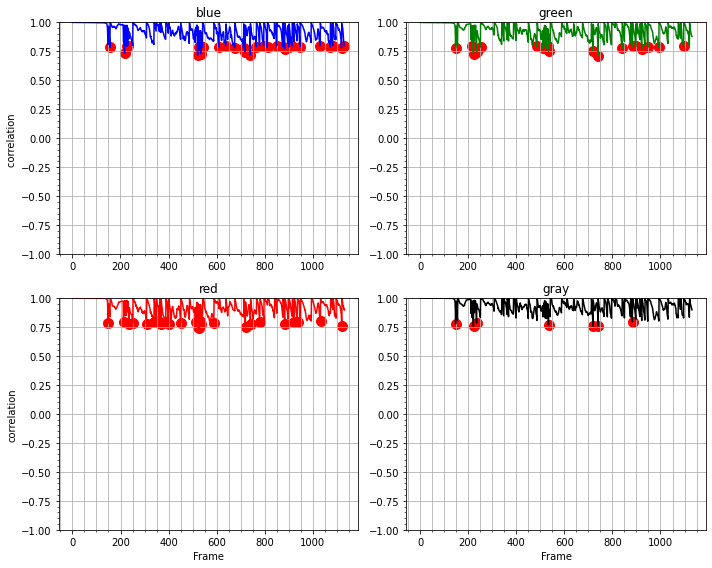

切り替え前フレーム147
切り替え前フレーム148
切り替えフレーム149
切り替えフレーム149(右)を含めた、前３フレーム取得
切り替え前フレーム155
切り替え前フレーム156
切り替えフレーム157
切り替えフレーム157(右)を含めた、前３フレーム取得
切り替え前フレーム212
切り替え前フレーム213
切り替えフレーム214
切り替えフレーム214(右)を含めた、前３フレーム取得
切り替え前フレーム216
切り替え前フレーム217
切り替えフレーム218
切り替えフレーム218(右)を含めた、前３フレーム取得
切り替え前フレーム221
切り替え前フレーム222
切り替えフレーム223
切り替えフレーム223(右)を含めた、前３フレーム取得
切り替え前フレーム225
切り替え前フレーム226
切り替えフレーム227
切り替えフレーム227(右)を含めた、前３フレーム取得
切り替え前フレーム229
切り替え前フレーム230
切り替えフレーム231
切り替えフレーム231(右)を含めた、前３フレーム取得
切り替え前フレーム234
切り替え前フレーム235
切り替えフレーム236
切り替えフレーム236(右)を含めた、前３フレーム取得
切り替え前フレーム250
切り替え前フレーム251
切り替えフレーム252
切り替えフレーム252(右)を含めた、前３フレーム取得
切り替え前フレーム307
切り替え前フレーム308
切り替えフレーム309
切り替えフレーム309(右)を含めた、前３フレーム取得
切り替え前フレーム338
切り替え前フレーム339
切り替えフレーム340
切り替えフレーム340(右)を含めた、前３フレーム取得
切り替え前フレーム347
切り替え前フレーム348
切り替えフレーム349
切り替えフレーム349(右)を含めた、前３フレーム取得
切り替え前フレーム361
切り替え前フレーム362
切り替えフレーム363
切り替えフレーム363(右)を含めた、前３フレーム取得
切り替え前フレーム367
切り替え前フレーム368
切り替えフレーム369
切り替えフレーム369(右)を含めた、前３フレーム取得
切り替え前フレーム387
切り替え前フレーム388
切り替えフレーム389
切り替えフレーム389(右)を含めた、前３フレーム取得
切り替え前フレーム3

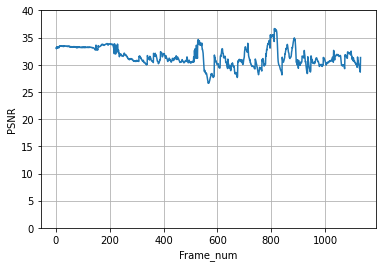

0.9start_smoothing:1
running on GPU ('0',)
replace all deconv with [nearest + conv]
replace all batchnorm with instancenorm
succesfully load nonlocal model:  checkpoints/video_moredata_l1/nonlocal_net_iter_76000.pth
succesfully load color model:  checkpoints/video_moredata_l1/colornet_iter_76000.pth
第一フレームカラー化参照画像セット
第一フレームを参照画像にセット&RGB+Grヒストグラム算出
参照画像変更148
カラー化参照画像を切り替え
参照画像変更150
カラー化参照画像を切り替え
参照画像変更153
カラー化参照画像を切り替え
参照画像変更160
カラー化参照画像を切り替え
参照画像変更213
カラー化参照画像を切り替え
参照画像変更215
カラー化参照画像を切り替え
参照画像変更218
カラー化参照画像を切り替え
参照画像変更221
カラー化参照画像を切り替え
参照画像変更224
カラー化参照画像を切り替え
参照画像変更227
カラー化参照画像を切り替え
参照画像変更230
カラー化参照画像を切り替え
参照画像変更233
カラー化参照画像を切り替え
参照画像変更236
カラー化参照画像を切り替え
参照画像変更240
カラー化参照画像を切り替え


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import time
import copy
import os
import shutil
import numpy as np
from matplotlib import pyplot as plt

#手法
RGB_histoguram = True
RGBgray_histoguram = None
#平滑化係数
#smoothing= 1.0

for a in np.arange(1, 2, 1):
  #smoothing =round(a, 3)
  smoothing=a
  
  for switch_num in range(1,5,3):         #RGB_histoguram:#1~3つ　RGBgray_histoguram#1~4つ
    for i in np.arange(0.8, 1.0, 0.1):
      x=float(format(i, '.1f'))
      print(str(x)+"start_smoothing:"+str(smoothing))

      os.chdir("/content/drive/MyDrive/now_project/Deep-Exemplar-based-Video-Colorization")






      

      ###########################################初期設定(Parameter&Path)###########################################################

        #切り替えするかどうか
      switching = True
      #閾値
      red_threshold =x
      green_threshold = x
      blue_threshold = x
      gray_threshold = x
      

      #PSNR算出用
      original_path = "/content/drive/MyDrive/Deep_learning/Dataset/material/shoes/shoes_SparkVideo.mp4"
      csv_name="shoes"
      method = f"RGBGray_{switch_num}_{x}"

      #input
      # カメラの場合path = 0 
      video_path = "/content/drive/MyDrive/Deep_learning/Dataset/material/shoes/shoes_SparkVideo.mp4"
      capture= cv2.VideoCapture(video_path)
      video_name = f"{method}_{csv_name}.avi"



      #カラー化フレーム保存先
      frame_path=f"/content/drive/MyDrive/now_project/result/frame/{csv_name}_{method}"
      if os.path.isdir(frame_path):
        shutil.rmtree(frame_path)
      os.makedirs(frame_path)

      #最終結果保存先
      output_path=f"/content/drive/MyDrive/now_project/result/movie/{csv_name}_{method}"
      if os.path.isdir(output_path):
        shutil.rmtree(output_path)
      os.makedirs(output_path)

      #########################################Parameter&Path#########################################################






      count=0
      SwitchingframeNum=0
      colors = ("b","g","r")
      onoff= []
      switch = []
      blue_result=[]
      green_result=[]
      red_result=[]
      gray_result=[]

      blue_plot=[]
      blue_value=[]

      red_plot=[]
      red_value=[]
      
      green_plot=[]
      green_value=[]
      
      gray_plot=[]
      gray_value=[]

      img_dict={}
      #timeリセット
      VGG_elapsed_time = 0
      Nonlocalne_elapsed_time = 0
      CorrelationMatrix_elapsed_time = 0
      Colorization_subnet_elapsed_time = 0

      #グラフ設定

      #figure()でグラフを表示する領域をつくり，figというオブジェクトにする．
      fig = plt.figure(figsize=(10,8))

      #add_subplot()でグラフを描画する領域を追加する．引数は行，列，場所
      ax1 = fig.add_subplot(2, 2, 1)
      ax2 = fig.add_subplot(2, 2, 2)
      ax3 = fig.add_subplot(2, 2, 3)
      ax4 = fig.add_subplot(2, 2, 4)

      c1,c2,c3,c4 = "blue","green","red","black"      # 各プロットの色
      l1,l2,l3,l4 = "blue","green","red","black"   # 各ラベル






      ######################colorization#####################################
      wls_filter_on = True
      lambda_value = 500
      sigma_color = 4

      image_size=[216 * 2, 384 * 2]

      transform = transforms.Compose([CenterPad(image_size), transform_lib.CenterCrop(image_size),
                                      RGB2Lab(), ToTensor(), Normalize()]
                                    )

      total_time = 0
      I_last_lab_predict = None

      frame_propagate=False, #type=bool, 
      image_size=[216 * 2, 384 * 2] #"the image size, eg. [216,384]")type=int,
      #parser.add_argument("--cuda", action="store_false")
      gpu_ids="0", #"separate by comma")type=str,
      #clip_path="./sample_videos/clips/v32" #"path of input clips")type=str
      #ref_path="./sample_videos/ref/v32"    # help="path of refernce images") type=str,
      #output_path="./sample_videos/output"# help="path of output clips")type=str

      #uDNNのベンチマークモードをオンにするかどうかのオプション。
      #Trueにするとオートチューナーがネットワークの構成に対して最適なアルゴリズムを見つけるため、高速化。
      #CNNのようにネットワークの入力サイズが変化しない場合はTrueにすることを推奨

      cudnn.benchmark = True
      print("running on GPU", gpu_ids)

        #clippathを/区切りでリストを作成.
        #リスト最後がそのファイル特有の名前なので[-1]で取り出している.
        #clip_name = clip_path.split("/")[-1]
        #指定したディレクトリのファイル・ディレクトリの一覧をリストで取得
        #refs = os.listdir(ref_path)
        #リスト（配列）の要素をソート
        #refs.sort()

        #ネットワーク指定&ネットワーク読み込み

      nonlocal_net = WarpNet(1)
      colornet = ColorVidNet(7)
      vggnet = VGG19_pytorch()
      vggnet.load_state_dict(torch.load("data/vgg19_conv.pth"))
      for param in vggnet.parameters():
        param.requires_grad = False

      nonlocal_test_path = os.path.join("checkpoints/", "video_moredata_l1/nonlocal_net_iter_76000.pth")
      color_test_path = os.path.join("checkpoints/", "video_moredata_l1/colornet_iter_76000.pth")
      print("succesfully load nonlocal model: ", nonlocal_test_path)
      print("succesfully load color model: ", color_test_path)
      nonlocal_net.load_state_dict(torch.load(nonlocal_test_path))
      colornet.load_state_dict(torch.load(color_test_path))

      #推論モードに切り替え
      nonlocal_net.eval()
      colornet.eval()
      vggnet.eval()
      #ネットワークをGPUに送信
      nonlocal_net.cuda()
      colornet.cuda()
      vggnet.cuda()
      ###################################################











      # 開始
      start_time = time.perf_counter()

      while True:
        # カメラ/動画の画像を1フレーム分取得
        ret, img = capture.read()
        if not ret:
          print("capture error!!")
          break

        count +=1

        #動画の第1フレームを参照画像にする
        if count==1:
          reference=img

          ###################colorization#####################
        
          frame_ref =cv2pil(reference)

          #unsqueezeで次元を増やした.(バッチ学習などのため),cudaでGPUに送信
          IB_lab_large = transform(frame_ref).unsqueeze(0).cuda()


          #interpolate、入力はミニバッチ,チャネル,奥行き,高さ
          IB_lab = torch.nn.functional.interpolate(IB_lab_large, scale_factor=0.5, mode="bilinear")
          #スライスでLを取得(index:0)
          IB_l = IB_lab[:, 0:1, :, :]
          #スライスでabを取得(index:1,2)
          IB_ab = IB_lab[:, 1:3, :, :]
          #自動微分を無効化(勾配計算用パラメータを保存しない)
          with torch.no_grad():
            I_reference_lab = IB_lab
            #スライスでLを取得(index:0)
            I_reference_l = I_reference_lab[:, 0:1, :, :]
            #スライスでabを取得(index:1,2)
            I_reference_ab = I_reference_lab[:, 1:3, :, :]
            #LabをRGBに変更

            I_reference_rgb = tensor_lab2rgb(torch.cat((uncenter_l(I_reference_l), I_reference_ab), dim=1))
            features_B = vggnet(I_reference_rgb, ["r12", "r22", "r32", "r42", "r52"], preprocess=True)

            print("第一フレームカラー化参照画像セット")

          #################################################

          for i,col in enumerate(colors):
            hist_one_frame = cv2.calcHist([reference],[i],None,[256],[0,256])
            if col == "b":
              hist_blue_ref = hist_one_frame
            elif col =="g":
              hist_green_ref = hist_one_frame
            elif col == "r":
              hist_red_ref = hist_one_frame
          gray_ref = cv2.cvtColor(reference, cv2.COLOR_BGR2GRAY)
          gray_ref_hist = cv2.calcHist([gray_ref],[0],None,[256],[0,256])

          print("第一フレームを参照画像にセット&RGB+Grヒストグラム算出")

        #1フレームごとに処理
        
        #plt.clf()

        #color
        for i, channel in enumerate(colors):
          hist_mobie2frame = cv2.calcHist([img],[i],None,[256],[0,256])

          if channel == "b":
            #残りフレームのヒストグラムより相関値を算出する
            hist_blue_movie=hist_mobie2frame
            blue_corr=np.corrcoef(hist_blue_ref.flatten(),hist_blue_movie.flatten())[0,1]
            if count==1:
              blue_result.append(blue_corr)
              law_blue_corr=blue_corr
              pre_blue_corr = blue_corr
            else:
              law_blue_corr = smoothing*blue_corr + (1-smoothing)*pre_blue_corr
              blue_result.append(law_blue_corr)
              pre_blue_corr = law_blue_corr
            

          elif channel =="g":
            #残りフレームのヒストグラムより相関値を算出する
            hist_green_movie=hist_mobie2frame
            green_corr=np.corrcoef(hist_green_ref.flatten(),hist_green_movie.flatten())[0,1] 
            if count==1:
              green_result.append(green_corr)
              law_green_corr=green_corr
              pre_green_corr = green_corr
            else:
              law_green_corr = smoothing*green_corr + (1-smoothing)*pre_green_corr
              green_result.append(law_green_corr)
              pre_green_corr = law_green_corr
            
            

          elif channel == "r":
            #残りフレームのヒストグラムより相関値を算出する
            hist_red_movie=hist_mobie2frame
            red_corr=np.corrcoef(hist_red_ref.flatten(),hist_red_movie.flatten())[0,1] 
            if count==1:
              red_result.append(red_corr)
              law_red_corr=red_corr
              pre_red_corr = red_corr
            else:
              law_red_corr = smoothing*red_corr + (1-smoothing)*pre_red_corr
              red_result.append(law_red_corr)
              pre_red_corr = law_red_corr
            
      #gray
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hist_gray_movie = cv2.calcHist([gray],[0],None,[256],[0,256])
        #残りフレームのヒストグラムより相関値を算出する
        gray_corr=np.corrcoef(gray_ref_hist.flatten(),hist_gray_movie.flatten())[0,1]
        if count==1:
          gray_result.append(gray_corr)
          law_gray_corr=gray_corr
          pre_gray_corr = gray_corr
        else:
          law_gray_corr = smoothing*gray_corr + (1-smoothing)*pre_gray_corr
          gray_result.append(law_gray_corr)
          pre_gray_corr = law_gray_corr
        




        #切り替え時の前画像フレーム表示のために、img一旦保持。ループで上書きされる
        #変化を見るため、切り替えフレーム含め、３フレーム前まで取得
        #pre_img_2：切り替え時より２前
        #pre_img_1:切り替え時より１前
        if count==1:
          pre_img_1 = img
        else:
          pre_img_2 = pre_img_1
          pre_img_1 = img

        #############################histoguram_switiching##########################################

        blue_switch="OFF"
        red_switch="OFF"
        green_switch="OFF"
        gray_switch="OFF"

      ##RGB_histoguram
        if RGB_histoguram:
          if law_blue_corr<= blue_threshold:
            blue_switch="ON"
            onoff.append(blue_switch)
            #else:
              #red_switch="OFF"
              #switch.append(blue_switch)

          if law_green_corr<=green_threshold:
            green_switch="ON"
            onoff.append(green_switch)
            #else:
              #red_switch="OFF"
              #switch.append(green_switch)

          if law_red_corr<=red_threshold:
            red_switch="ON"
            onoff.append(red_switch)
            #else:
              #red_switch="OFF"
              #switch.append(red_switch)

          if onoff.count("ON") >= switch_num:
            switch.append("ON")

      #RGBgray_histoguram
        elif RGBgray_histoguram:
          if law_blue_corr<= blue_threshold:
            blue_switch="ON"
            onoff.append(blue_switch)
            #else:
              #red_switch="OFF"
              #switch.append(blue_switch)

          if law_green_corr<=green_threshold:
            green_switch="ON"
            onoff.append(green_switch)
            #else:
              #red_switch="OFF"
              #switch.append(green_switch)

          if law_red_corr<=red_threshold:
            red_switch="ON"
            onoff.append(red_switch)
            #else:
              #red_switch="OFF"
              #switch.append(red_switch)

          if law_gray_corr<=gray_threshold:
            gray_switch="ON"
            onoff.append(gray_switch)
            #else:
              #red_switch="OFF"
              #switch.append(red_switch)

          if onoff.count("ON") >= switch_num:
            switch.append("ON")


        ######################################################################

      #検出されたら参照画像切り替えが行われる()
      # if  部分は　or で結合

        if switching:
          if switch :
            reference = img


            #カラー化DeepLearningに知らせる
            print("参照画像変更"+str(count))

            #カラー化DeepLearningにreferenceを送信する

          ##########################colorization##############################
            frame_ref = cv2pil(reference)
            #unsqueezeで次元を増やした.(バッチ学習などのため),cudaでGPUに送信
            IB_lab_large = transform(frame_ref).unsqueeze(0).cuda()


            #interpolate、入力はミニバッチ,チャネル,奥行き,高さ
            IB_lab = torch.nn.functional.interpolate(IB_lab_large, scale_factor=0.5, mode="bilinear")
            #スライスでLを取得(index:0)
            IB_l = IB_lab[:, 0:1, :, :]
            #スライスでabを取得(index:1,2)
            IB_ab = IB_lab[:, 1:3, :, :]
            #自動微分を無効化(勾配計算用パラメータを保存しない)
            with torch.no_grad():
              I_reference_lab = IB_lab
              #スライスでLを取得(index:0)
              I_reference_l = I_reference_lab[:, 0:1, :, :]
              #スライスでabを取得(index:1,2)
              I_reference_ab = I_reference_lab[:, 1:3, :, :]
              #LabをRGBに変更

              I_reference_rgb = tensor_lab2rgb(torch.cat((uncenter_l(I_reference_l), I_reference_ab), dim=1))
              features_B = vggnet(I_reference_rgb, ["r12", "r22", "r32", "r42", "r52"], preprocess=True)

            print("カラー化参照画像を切り替え")

          ################################################################

          
            #切り替え画像を辞書型に保存
            img_dict["切り替え前フレーム"+str(count-2)]=pre_img_2
            img_dict["切り替え前フレーム"+str(count-1)]=pre_img_1
            img_dict["切り替えフレーム"+str(count)]=img



            #切り替えタイミングをgrayにプロットする。値を保持
            if blue_switch=="ON":
              blue_plot.append(copy.copy(count))
              blue_value.append(copy.copy(law_blue_corr))

            if green_switch=="ON":
              green_plot.append(copy.copy(count))
              green_value.append(copy.copy(law_green_corr))

            if red_switch=="ON":
              red_plot.append(copy.copy(count))
              red_value.append(copy.copy(law_red_corr))

            if gray_switch=="ON":
              gray_plot.append(copy.copy(count))
              gray_value.append(copy.copy(law_gray_corr))

            #参照画像が切り替わる
            hist_blue_ref=hist_blue_movie
            hist_green_ref=hist_green_movie
            hist_red_ref=hist_red_movie
            gray_ref_hist=hist_gray_movie

            SwitchingframeNum +=1


        #onoff&switchリストを空に
      
        onoff.clear()
        switch.clear()    

        ###############################colorization##########################

        #input_frame=cv2pil(img)
        #frame1 = input_frame.convert('L')

        frame1=cv2pil(img)
        frame1=frame1.convert("L").convert("RGB")
        #gray(C:1)→RGB(C:3)のようにC数調節



        #for index, frame_name in enumerate(tqdm(filenames)):
          #入力フレームを一枚ずつ取り出し
          #frame1 = Image.open(os.path.join(input_path, frame_name))
        #frame1=cv2pil(gray)
        IA_lab_large = transform(frame1).unsqueeze(0).cuda()
        IA_lab = torch.nn.functional.interpolate(IA_lab_large, scale_factor=0.5, mode="bilinear")

          #スライスでL成分,ab成分をそれぞれ取り出し

        IA_l = IA_lab[:, 0:1, :, :]
        IA_ab = IA_lab[:, 1:3, :, :]
          
        if I_last_lab_predict is None:
          if frame_propagate:
            I_last_lab_predict = IB_lab
          else:
            I_last_lab_predict = torch.zeros_like(IA_lab).cuda()

              # フレームカラー化を実行
        with torch.no_grad():
          I_current_lab = IA_lab
          I_current_ab_predict, I_current_nonlocal_lab_predict, features_current_gray = frame_colorization(
              I_current_lab,
              I_reference_lab,
              I_last_lab_predict,
              features_B,
              vggnet,
              nonlocal_net,
              colornet,
              feature_noise=0,
              temperature=1e-10,)
          I_last_lab_predict = torch.cat((IA_l, I_current_ab_predict), dim=1)



              # カラー化した後サイズに戻す
              # upsampling
          curr_bs_l = IA_lab_large[:, 0:1, :, :]
          curr_predict = (
              torch.nn.functional.interpolate(I_current_ab_predict.data.cpu(), scale_factor=2, mode="bilinear") * 1.25
              )

          # filtering
          if wls_filter_on:
            guide_image = uncenter_l(curr_bs_l) * 255 / 100
            wls_filter = cv2.ximgproc.createFastGlobalSmootherFilter(
                guide_image[0, 0, :, :].cpu().numpy().astype(np.uint8), lambda_value, sigma_color
                )
            curr_predict_a = wls_filter.filter(curr_predict[0, 0, :, :].cpu().numpy())
            curr_predict_b = wls_filter.filter(curr_predict[0, 1, :, :].cpu().numpy())
            curr_predict_a = torch.from_numpy(curr_predict_a).unsqueeze(0).unsqueeze(0)
            curr_predict_b = torch.from_numpy(curr_predict_b).unsqueeze(0).unsqueeze(0)
            curr_predict_filter = torch.cat((curr_predict_a, curr_predict_b), dim=1)
            IA_predict_rgb = batch_lab2rgb_transpose_mc(curr_bs_l[:32], curr_predict_filter[:32, ...])
          else:
            IA_predict_rgb = batch_lab2rgb_transpose_mc(curr_bs_l[:32], curr_predict[:32, ...])

              #　カラー化後保存    
              # save the frames
          #frame_path="/content/clip"
          save_frames(IA_predict_rgb,frame_path, count)

          #　ループ終了    
        
        ####################################################################
      #　ループ終了   

      # output video
      #video_name = "video.avi"
      #clip_output_path = os.path.join(output_path, clip_name)
      #mkdir_if_not(clip_output_path)
      folder2vid(image_folder=frame_path, output_dir=output_path, filename=video_name)
      print()

      #終了
      end_time = time.perf_counter()
      # 経過時間を出力(秒)
      elapsed_time = end_time - start_time
      print(f"カラー化終了:+{elapsed_time}")

      #==========ここまでカラー化==============#


      #################time###################

      print("VGG_elapsed_time"+str(VGG_elapsed_time))
      print("Nonlocalne_elapsed_time"+str(Nonlocalne_elapsed_time))
      print("CorrelationMatrix_elapsed_time"+str(CorrelationMatrix_elapsed_time))
      print("Colorization_subnet_elapsed_time"+str(Colorization_subnet_elapsed_time))
      










      #==========ヒストグラム相関値を表示し、保存する===========#

      print("ヒストグラム相関値をグラフ表示")

      #グラフ設定
      ax1.plot(blue_result, color=c1, label=l1)
      ax1.set_title("blue")
      ax1.set_ylim(-1,1)
      ax1.set_ylabel("correlation ")
      ax1.minorticks_on()
      ax1.grid(which = "both", axis="x")
      ax1.grid(axis="y")
      if blue_plot :
        ax1.scatter(blue_plot, blue_value,s=100,c="r")

      ax2.plot(green_result, color=c2, label=l2)
      ax2.set_title("green")
      ax2.set_ylim(-1,1)
      ax2.minorticks_on()
      ax2.grid(which = "both", axis="x")
      ax2.grid(axis="y")
      if green_plot :
        ax2.scatter(green_plot, green_value,s=100,c="r")

      ax3.plot(red_result,color=c3, label=l3)
      ax3.set_title("red")
      ax3.set_ylim(-1,1)
      ax3.set_xlabel("Frame")
      ax3.set_ylabel("correlation")
      ax3.minorticks_on()
      ax3.grid(which = "both", axis="x")
      ax3.grid(axis="y")
      if red_plot :
        ax3.scatter(red_plot, red_value,s=100,c="r")

      ax4.plot(gray_result, color=c4, label=l4)
      ax4.set_title("gray")
      ax4.set_ylim(-1,1)
      ax4.set_xlabel("Frame")
      ax4.minorticks_on()
      ax4.grid(which = "both", axis="x")
      ax4.grid(axis="y")
      if gray_plot :
        ax4.scatter(gray_plot, gray_value,s=100,c="r")




      #図が重ならないようにする
      fig.tight_layout()            
      plt.show()

      #グラフを保存する
      os.chdir(output_path)
      os.makedirs("./analysis/corr_histoguram")
      os.chdir("./analysis/corr_histoguram")
      fig.savefig(f"{method}_corr_histoguram.png")

      #==========================終====================#









      #=========================切り替え画像確認&保存=======================#

      #2フレーム前から確認,一番右が切り替え時フレーム

      def hconcat_resize_min(im_list, interpolation=cv2.INTER_CUBIC):
          h_min = min(im.shape[0] for im in im_list)
          im_list_resize = [cv2.resize(im, (int(im.shape[1] * h_min / im.shape[0]), h_min), interpolation=interpolation)
                            for im in im_list]
          return cv2.hconcat(im_list_resize)

      #一つ上に戻る
      os.chdir('../')
      os.mkdir("./switch_frame")
      #作ったディレクトリに移動
      os.chdir("./switch_frame")

      img_count=0

      for frame_count,switch_frame in img_dict.items():
        img_count+=1
        print(frame_count)
        if img_count%3 ==1:
          im1=switch_frame
        elif img_count%3 == 2:
          im2=switch_frame
        elif img_count%3 == 0:
          im3=switch_frame
          name = frame_count
          im_h_resize = hconcat_resize_min([im1, im2, im3])
          cv2.imwrite(f'{name}.jpg', im_h_resize)
          print(f"{frame_count}(右)を含めた、前３フレーム取得")


      #======================終=======================#







      #=====================PSNR算出=================#
      #カレントディレクトリにCSVが生成される

      os.chdir('../')

      os.mkdir("./PSNR")
      os.chdir("./PSNR")

      import cv2
      import csv
      import copy 

      #ファイル名を選択する(csvファイルの命名)

      #生成ファイル名

      #csv_name="BirdRose"
      #method = "RGB_0.3"

      #オリジナル映像を読み込み、フレームに変換
      original_capture= cv2.VideoCapture(original_path)


      #比較したい圧縮後動画を読み込み、フレームに変換
      Comparison_path = f"{output_path}/{video_name}"
      print(Comparison_path )
      output_capture= cv2.VideoCapture(Comparison_path)


      #フレーム毎のPSNRを保持する、辞書型配列を作成
      PSNR_frame = {}
      count = 0
      print(f"{csv_name}:PSNR算出開始")



      while True:
      # カメラ/動画の画像を1フレーム分取得
        count += 1

        original_ret, original_img = original_capture.read()
        if not original_ret:
          print(f"{csv_name}original capture error!!")
          break

        output_ret, output_img = output_capture.read()
        if not output_ret:
          print(f"{csv_name}Comparison capture error!!")
          break

        #ループ一週目サイズ確認
        if count==1:
          print(f"{csv_name}/original_img"+str(original_img.shape))
          print(f"{csv_name}/Comparison_img"+str(output_img.shape))

        #比較対象をオリジナルサイズにリサイズする(同サイズ比較）
        #output_img_resize = cv2.resize(output_img,dsize=(original_img.shape[1],original_img.shape[0]))

        ##オリジナルを比較対象サイズにリサイズする
        #original_img_resize = cv2.resize(original_img,dsize=(output_img.shape[1],output_img.shape[0]))


        #ループ一週目のみサイズ確認
        if count==1:
          print(f"{csv_name}original_img_resize"+str(original_img.shape))

        #フレーム毎にPSNRを計算
        PSNR=cv2.PSNR(original_img,output_img)
        #print(PSNR)

        #辞書型配列にフレームnumberとPSNRを追加していく
        
        PSNR_frame[count]=PSNR


        #ループ終了後
      print(PSNR_frame)

          #各フレームの値を取り出し合計する
      PSNR_sum=sum(PSNR_frame.values())
        #動画全体のPSNR平均値をとる。
      PSNR_movie=PSNR_sum/len(PSNR_frame)
      #辞書型にして保存
      result={"動画名":csv_name,"手法":method,"合計フレーム数":len(PSNR_frame),"フレーム毎のPSNR合計値":PSNR_sum,"動画全体の平均PSNR":PSNR_movie,}
      print(result)

      #resultをcsvファイルにして保存(現在の場所に保存される)
      import pandas as pd
      df = pd.DataFrame({"MovieName":csv_name,
                        "method":method,
                        "smoothing":smoothing,
                        "time":elapsed_time,
                        "SwitchingframeNum":SwitchingframeNum,
                        "FrameSum":[len(PSNR_frame)],
                        "PSNRSum":[PSNR_sum],
                        "moviePSNR":[PSNR_movie]})
      df = df.set_index('MovieName')
      csv_name=f"{csv_name}_{method}.csv"
      df.to_csv(csv_name, encoding="shift_jis")

      print(f"{csv_name}算出&保存終了")


      #PSNRとフレームのグラフを作成し、保存する
      #フレーム毎のPSNRは辞書型配列に保存されている

      #辞書に含まれるキーの一覧を取得
      Frame_num = list(PSNR_frame.keys())
      Frame_PSNR = list(PSNR_frame.values())

      #print(Frame_num)
      #print(Frame_PSNR)
      x=Frame_num
      y = Frame_PSNR

      fig = plt.figure()
      plt.plot(x, y)
      plt.xlabel('Frame_num')
      plt.ylabel('PSNR')
      plt.ylim(0,40)
      #plt.minorticks_on()
      #plt.grid(which = "both", axis="x")
      plt.grid()
      plt.show()

      fig.savefig(f'{method}PSNR.png')


  #==============================終===================================
  print("全行程終了")